# Implement

In [ ]:
!pip install zuko
!pip install matplotlib
!pip install torchdiffeq
!pip install torchmetrics
!pip install torch-fidelity
!pip install torchcfm

In [2]:
import torch
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchcfm.models.unet import UNetModel
import torchdiffeq
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

## Optimal Transport and 2 Loss

In [3]:
class OptimalTransportAndTwoLoss:
    def __init__(self, sigma_min: float = 0.001):
        super().__init__()
        self.sigma_min = sigma_min
        self.epsilon = 1e-5
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def psi_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Conditional Flow Maching with Optimal Transport

        Args:
            x (torch.Tensor): new state of sample
            x_1 (torch.Tensor): condition state to generate new sample
            t (torch.Tensor): random at step t for Mean and Variance of OT Formulation with range (0, 1)

        Returns:
            torch.Tensor: Flow matching with optimal transport at x with condition x_1 and step t
        """

        t = t[:, :, None, None]
        return (1 - (1 - self.sigma_min) * t) * x + t * x_1

    def loss(self,
             vector_field_t: nn.Module,
             x_1: torch.Tensor,
             class_condition: torch.Tensor,
             num_classes: int) -> torch.Tensor:
        """
        Compute the loss of the flow matching with optimal transport

        Args:
            vector_field_t (nn.Module): Network to calculate Vector Field at step t
            x_1 (torch.Tensor): Condition state x_1
            class_condition (int): Class condition for a batch of samples

        Returns:
            torch.Tensor: Loss of the flow matching with optimal transport
        """

        t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.epsilon)
        t = t[:, None]

        # Random Noise
        x_0 = torch.randn_like(x_1)

        # Calculate the vector field at step t
        psi_t = self.psi_t(x_0, x_1, t)

        # Calculate the vector field at step t with psi_t as input
        v_psi = vector_field_t(t[:, 0], psi_t, class_condition)

        # Calculate derivative of psi_t at x_0 respect to t
        d_psi = x_1 - (1 - self.sigma_min) * x_0

        # Calculate the loss
        return torch.mean((v_psi - d_psi) ** 2)

    def loss_flow_matching(self, Online_v_t, Pretrained_v_t, Generator):
        t = (torch.rand(1, device=self.device) + torch.arange(10, device=self.device) / 10) % (1 - self.epsilon)
        t = t[:, None]
        t_steps = torch.linspace(0, 1, 2, device=self.device)
        class_condition = torch.tensor([x for x in range(10)], device=self.device)

        z = torch.randn(10, 1, 28, 28, device=self.device)

        with torch.no_grad():
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                traj = torchdiffeq.odeint(
                    lambda _t, _x: Generator(_t, _x, class_condition),
                    z,
                    t_steps,
                    atol=1e-4,
                    rtol=1e-4,
                    method="euler",
                )

        x_0 = traj[-1]
        psi_t = self.psi_t(z, x_0, t)

        d_psi = x_0 - (1 - self.sigma_min) * z
        online_train = Online_v_t(t[:, 0], psi_t, class_condition)

        loss_flow_matching = torch.mean((online_train - d_psi) ** 2)

        # Free up GPU memory
        torch.cuda.empty_cache()

        return loss_flow_matching

    def loss_generator_matching(self, Online_v_t, Pretrained_v_t, Generator):
        t = (torch.rand(1, device=self.device) + torch.arange(10, device=self.device) / 10) % (1 - self.epsilon)
        t = t[:, None]
        t_steps = torch.linspace(0, 1, 2, device=self.device)
        class_condition = torch.tensor([x for x in range(10)], device=self.device)

        z = torch.randn(10, 1, 28, 28, device=self.device)

        with torch.autocast(device_type="cuda", dtype=torch.float16):
            traj = torchdiffeq.odeint(
                lambda _t, _x: Generator(_t, _x, class_condition),
                z,
                t_steps,
                atol=1e-4,
                rtol=1e-4,
                method="euler",
            )

        x_0 = traj[-1]

        psi_t = self.psi_t(z, x_0, t)
        d_psi = x_0 - (1 - self.sigma_min) * z

        pre_train = Pretrained_v_t(t[:, 0], psi_t, class_condition)
        online_train = Online_v_t(t[:, 0], psi_t, class_condition)

        l1 = torch.mean((pre_train - online_train) ** 2)
        l2 = torch.mean(2 * ((pre_train - online_train) * (online_train - d_psi)))

        # Free up GPU memory
        torch.cuda.empty_cache()

        return l1 + l2, x_0




## Data

In [4]:
n_epochs = 100 #@param {'type':'integer'}
batch_size = 128 #@param {'type':'integer'}
lr = 0.0005 #@param {'type':'number'}
num_classes = 10 #@param {'type':'integer'}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mode_train = 'Generator' #@param ['Generator', 'Matching']
dataset_name = 'MNIST' #@param ['MNIST', 'CIFAR10']

In [5]:
num_images_per_label = 6000  # Number of images per label

# Load dataset
if dataset_name == 'MNIST':
    dataset = MNIST(root='.', train=True, download=True, transform=ToTensor())
elif dataset_name == 'CIFAR10':
    dataset = CIFAR10(root='.', train=True, download=True, transform=ToTensor())
else:
    raise ValueError("Unsupported dataset. Please choose 'MNIST' or 'CIFAR10'.")

# Custom dataset to filter 1000 samples per label
class FilteredDataset(TensorDataset):
    def __init__(self, dataset, num_images_per_label):
        self.dataset = dataset
        self.num_images_per_label = num_images_per_label
        self.filtered_data = []
        self._filter_dataset()

    def _filter_dataset(self):
        label_counts = {i: 0 for i in range(len(self.dataset.classes))}
        for image, label in self.dataset:
            if label_counts[label] < self.num_images_per_label:
                self.filtered_data.append((image, label))
                label_counts[label] += 1
            if all(count >= self.num_images_per_label for count in label_counts.values()):
                break

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, index):
        return self.filtered_data[index]


In [6]:
filtered_dataset = FilteredDataset(dataset, num_images_per_label)
data_loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

In [7]:
print(len(data_loader.dataset))
print(data_loader.dataset[0][0].shape)

58862
torch.Size([1, 28, 28])


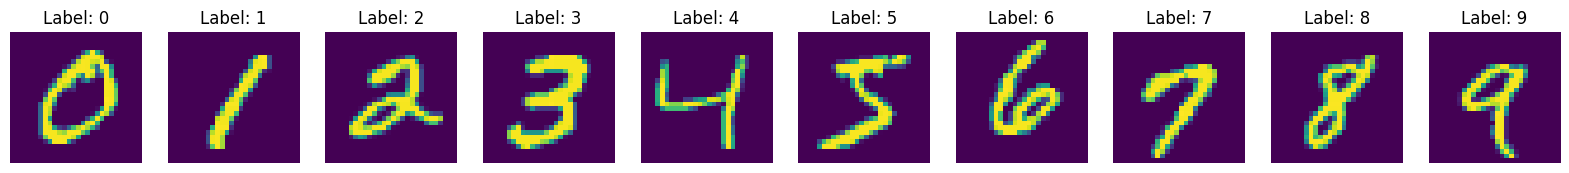

In [8]:
# Print 10 label example in RGB and also label
plt.figure(figsize=(20, 20))

image = []

amount_label = 10

# Extract image with label
for label in range(amount_label):
    image_index = next((i for i, (img, lbl) in enumerate(data_loader.dataset) if lbl == label), None)
    if image_index is not None:
        image.append(data_loader.dataset[image_index])
        plt.subplot(1, amount_label, label + 1)
        plt.imshow(image[-1][0].permute(1, 2, 0))  # Permute to (H, W, C) for displaying
        plt.title(f"Label: {image[-1][1]}")
        plt.axis('off')

plt.show()


## Initialize Model

In [9]:
model = OptimalTransportAndTwoLoss()
Pretrained_v_t = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)

Online_v_t = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)

Generator = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)

In [10]:
# Find last folder in checkpoints
import os
import datetime

def find_last_folder():
    folders = os.listdir(f"./checkpoints/{dataset_name}")
    last_folder = sorted(folders)[-1]
    return last_folder

folder_lastest_checkpoint = find_last_folder()

print("Load checkpoint: ", folder_lastest_checkpoint)
Pretrained_v_t.load_state_dict(torch.load(f"./checkpoints/{dataset_name}/{folder_lastest_checkpoint}/Pretrained_v_t.pt", weights_only=False, map_location=device))
Online_v_t.load_state_dict(torch.load(f"./checkpoints/{dataset_name}/{folder_lastest_checkpoint}/Online_v_t.pt", weights_only=False, map_location=device))
Generator.load_state_dict(torch.load(f"./checkpoints/{dataset_name}/{folder_lastest_checkpoint}/Generator.pt", weights_only=False, map_location=device))

Load checkpoint:  2025-01-06-04-43-45


<All keys matched successfully>

In [ ]:
losses = []
optimizer_pretrain_model = torch.optim.Adam(Pretrained_v_t.parameters())
optimizer_online_model = torch.optim.SGD(Online_v_t.parameters())
optimizer_generator_model = torch.optim.SGD(Generator.parameters())

## Run algorithm for Flow Matching Model

In [ ]:
import os
from datetime import datetime

if mode_train == 'Matching':
    date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

    if os.path.exists(f"./checkpoints/") == False:
        os.makedirs(f"./checkpoints/")

    if os.path.exists(f"./checkpoints/{dataset_name}/") == False:
        os.makedirs(f"./checkpoints/{dataset_name}/")

    if os.path.exists(f"./checkpoints/{dataset_name}/{date}/") == False:
        os.makedirs(f"./checkpoints/{dataset_name}/{date}/")
        for param in Pretrained_v_t.parameters():
            param.requires_grad = True

    # Early stopping parameters
    patience = 10  # Number of epochs to wait for improvement
    best_loss = float('inf')
    no_improve_epochs = 0

    for epoch in tqdm(range(n_epochs), ncols=88):
        epoch_loss = 0  # Track epoch loss
        for batch_idx, (x_1, y) in enumerate(data_loader):
            x_1, y = x_1.to(device), y.to(device)

            # Compute loss
            loss = model.loss(Pretrained_v_t, x_1, class_condition=y, num_classes=num_classes)

            # Zero gradients
            optimizer_pretrain_model.zero_grad()

            # Standard backward pass
            loss.backward()

            # Optimizer step
            optimizer_pretrain_model.step()

            # Accumulate loss
            epoch_loss += loss.item()

            # Debug: Check for NaN loss
            if torch.isnan(loss):
                print(f"NaN detected in batch {batch_idx}. Skipping...")
                continue

        # Log epoch loss
        avg_loss = epoch_loss / len(data_loader)
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {avg_loss:.4f}")

        # Early stopping logic
        if avg_loss < best_loss:
            best_loss = avg_loss
            no_improve_epochs = 0  # Reset counter
            print("Improvement detected, saving model...")
            # Optionally save the model here
            torch.save(Pretrained_v_t.state_dict(), f"./checkpoints/{dataset_name}/{date}/Pretrained_v_t.pt")
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epochs.")

        if no_improve_epochs >= patience:
            print("Early stopping triggered.")
            break


## Run algorithm for Generator Matching

  0%|                                                         | 0/50000 [00:00<?, ?it/s]

Epoch [1/10] - Loss Flow Matching: 0.0646 - Loss Generator Matching: 0.0407


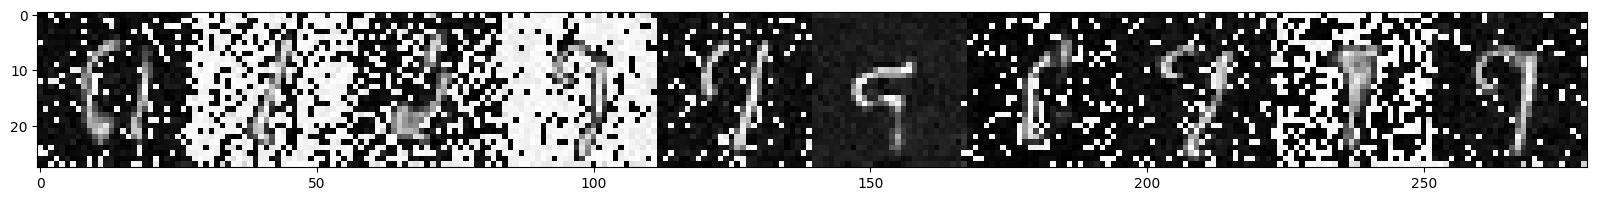

  2%|█                                           | 1250/50000 [02:27<1:37:52,  8.30it/s]

Epoch [1251/10] - Loss Flow Matching: 0.0839 - Loss Generator Matching: 0.0233


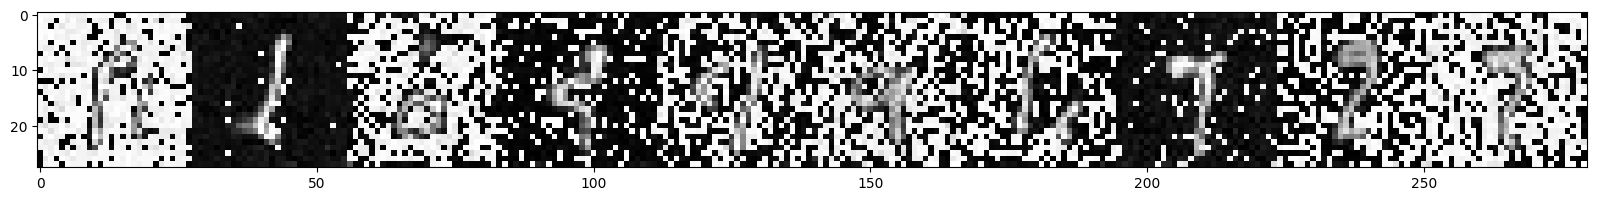

  5%|██▏                                         | 2500/50000 [04:53<1:30:52,  8.71it/s]

Epoch [2501/10] - Loss Flow Matching: 0.0621 - Loss Generator Matching: 0.0410


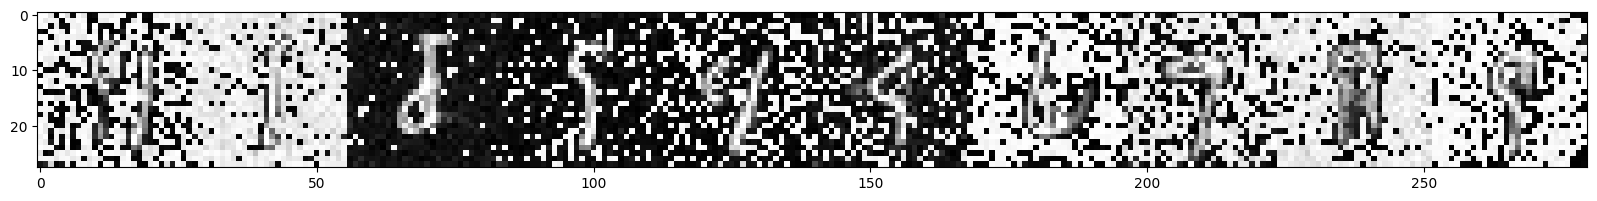

  8%|███▎                                        | 3750/50000 [07:23<1:18:46,  9.78it/s]

Epoch [3751/10] - Loss Flow Matching: 0.0574 - Loss Generator Matching: 0.0322


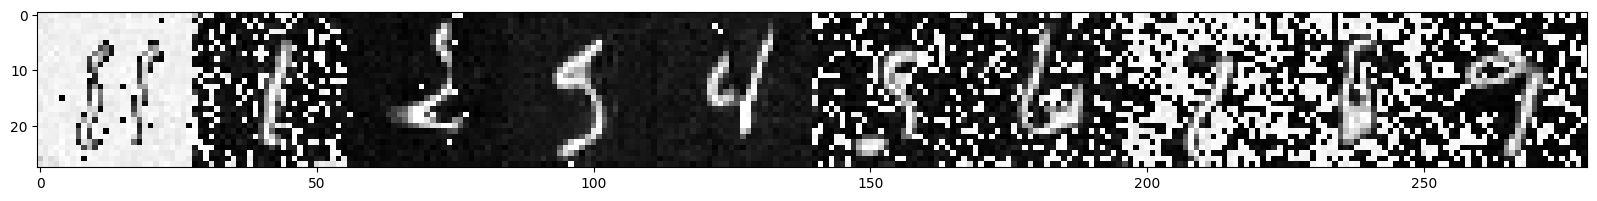

 10%|████▍                                       | 5000/50000 [09:42<1:26:03,  8.72it/s]

Epoch [5001/10] - Loss Flow Matching: 0.0713 - Loss Generator Matching: 0.0241


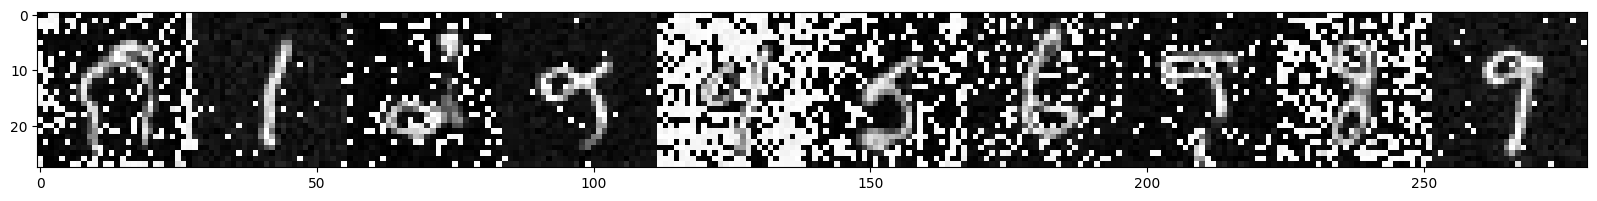

 12%|█████▌                                      | 6250/50000 [12:01<1:16:04,  9.58it/s]

Epoch [6251/10] - Loss Flow Matching: 0.0542 - Loss Generator Matching: 0.0257


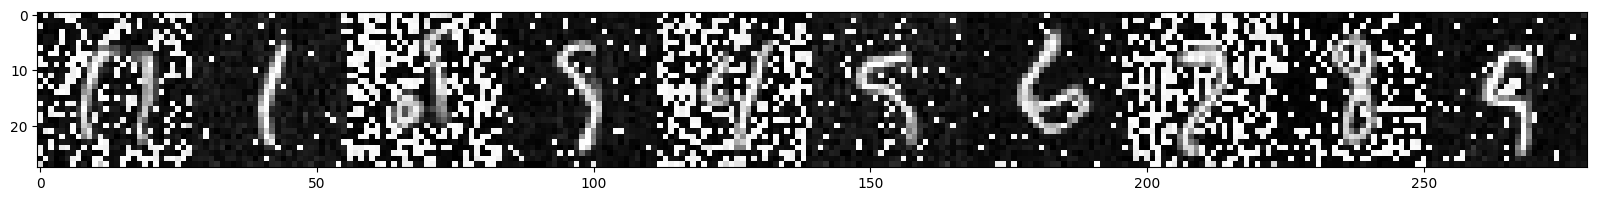

 15%|██████▌                                     | 7500/50000 [14:20<1:20:13,  8.83it/s]

Epoch [7501/10] - Loss Flow Matching: 0.0751 - Loss Generator Matching: 0.0233


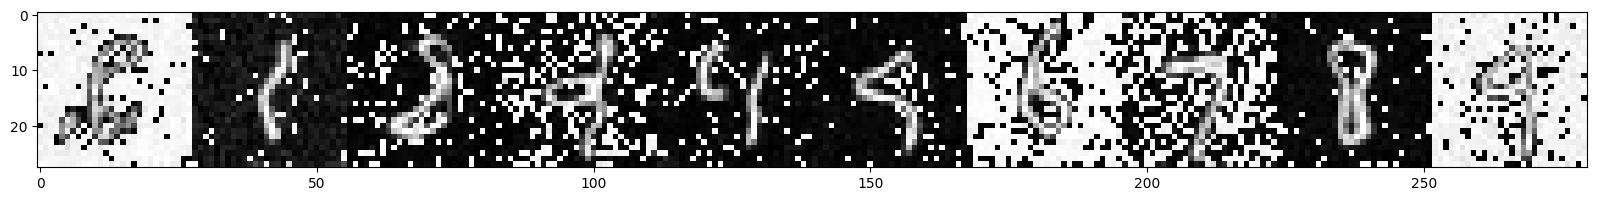

 18%|███████▋                                    | 8750/50000 [16:56<1:32:00,  7.47it/s]

Epoch [8751/10] - Loss Flow Matching: 0.1000 - Loss Generator Matching: 0.0354


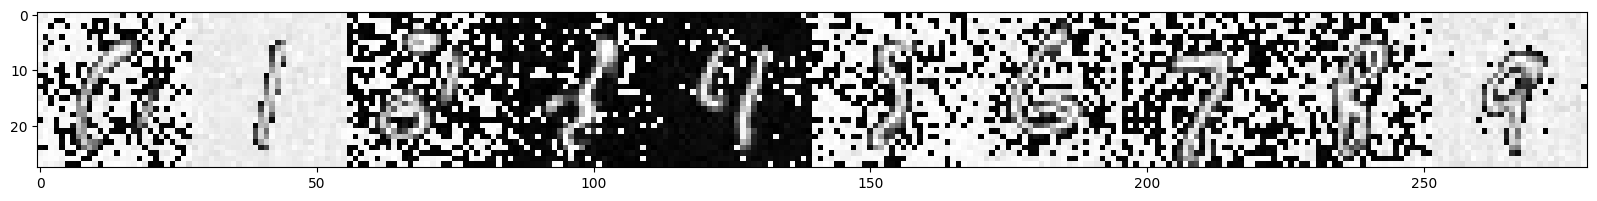

 20%|████████▌                                  | 10000/50000 [19:51<1:17:50,  8.56it/s]

Epoch [10001/10] - Loss Flow Matching: 0.1030 - Loss Generator Matching: 0.0333


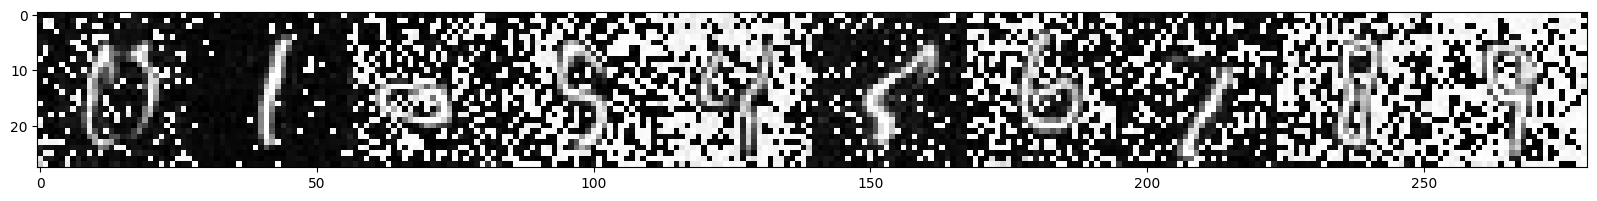

 22%|█████████▋                                 | 11250/50000 [22:16<1:13:23,  8.80it/s]

Epoch [11251/10] - Loss Flow Matching: 0.0845 - Loss Generator Matching: 0.0330


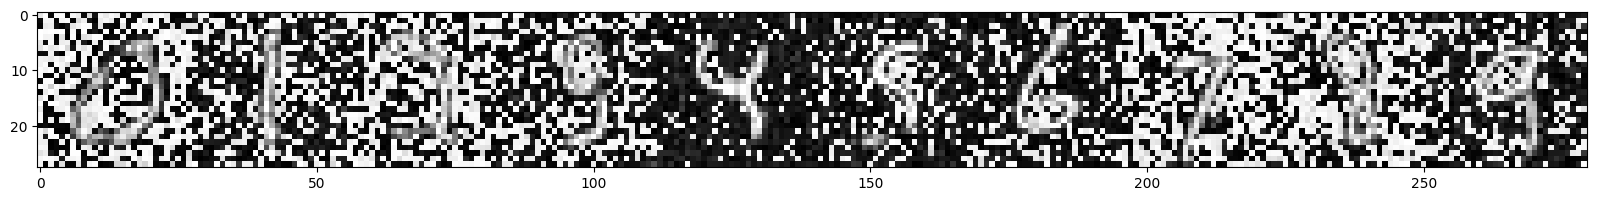

 25%|██████████▊                                | 12500/50000 [24:36<1:11:00,  8.80it/s]

Epoch [12501/10] - Loss Flow Matching: 0.0704 - Loss Generator Matching: 0.0191


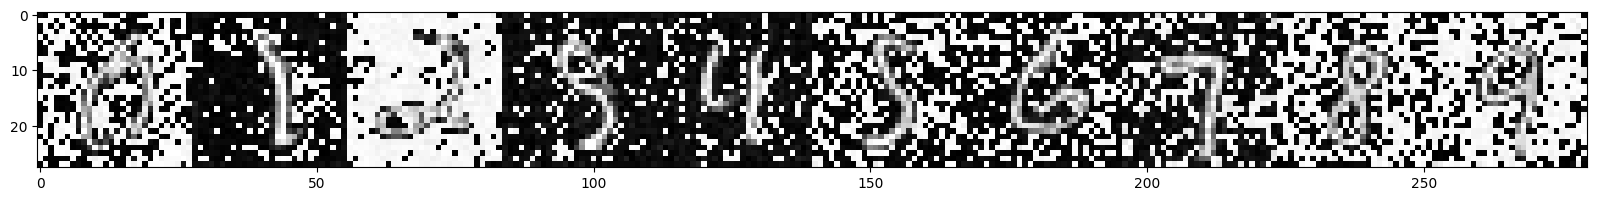

 28%|███████████▊                               | 13750/50000 [27:07<1:10:41,  8.55it/s]

Epoch [13751/10] - Loss Flow Matching: 0.0949 - Loss Generator Matching: 0.0242


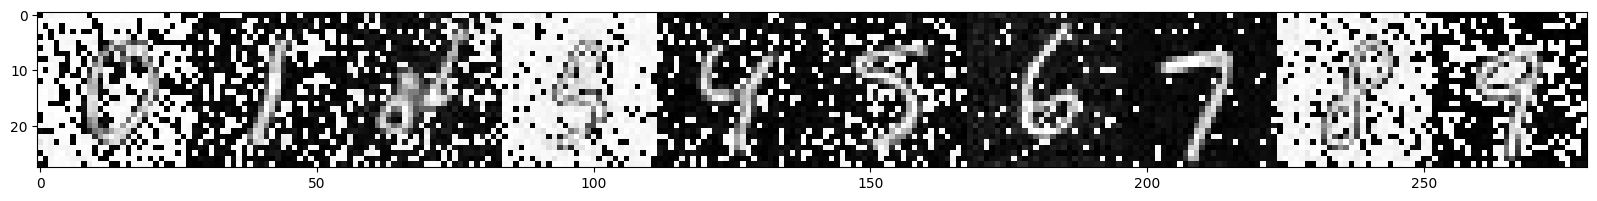

 30%|████████████▉                              | 15000/50000 [29:35<1:13:10,  7.97it/s]

Epoch [15001/10] - Loss Flow Matching: 0.0638 - Loss Generator Matching: 0.0288


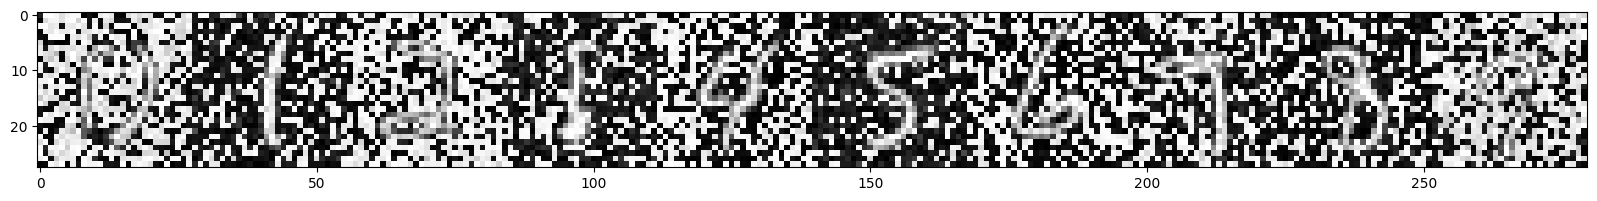

 32%|██████████████▋                              | 16250/50000 [32:00<58:48,  9.57it/s]

Epoch [16251/10] - Loss Flow Matching: 0.0738 - Loss Generator Matching: 0.0409


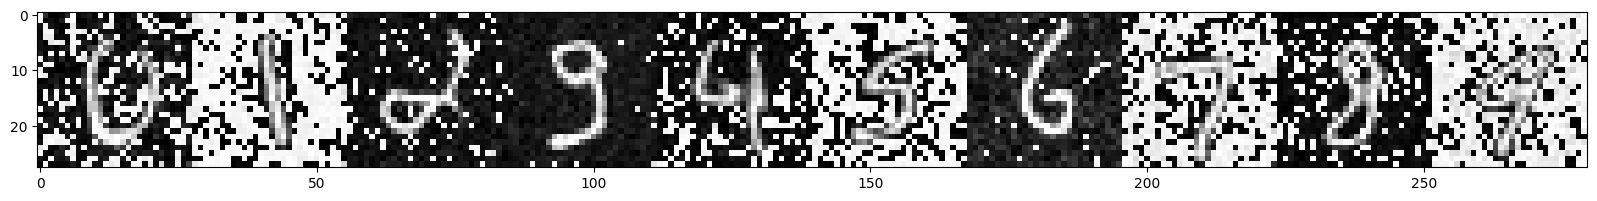

 35%|███████████████                            | 17500/50000 [34:23<1:02:04,  8.73it/s]

Epoch [17501/10] - Loss Flow Matching: 0.0632 - Loss Generator Matching: 0.0114


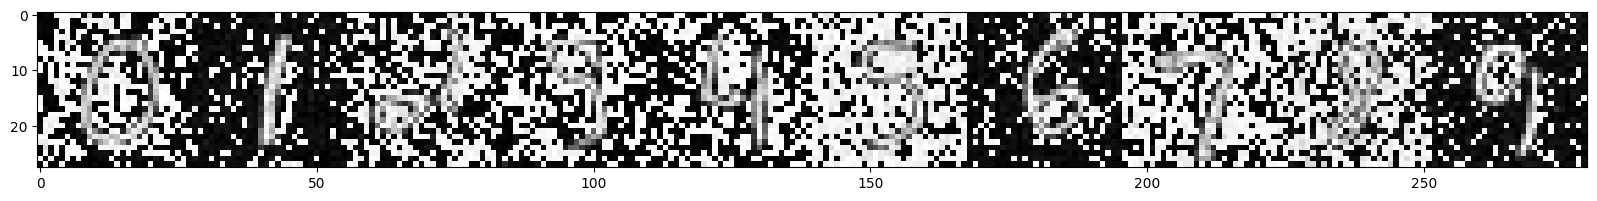

 38%|████████████████▉                            | 18750/50000 [36:54<58:32,  8.90it/s]

Epoch [18751/10] - Loss Flow Matching: 0.0847 - Loss Generator Matching: 0.0107


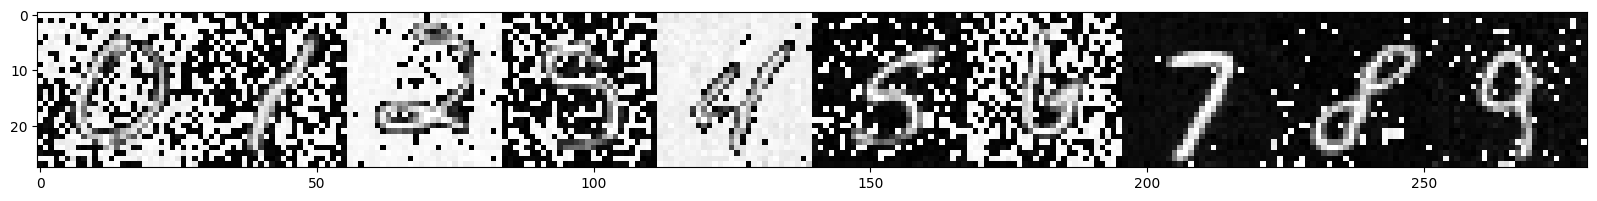

 40%|██████████████████                           | 20000/50000 [39:19<57:18,  8.72it/s]

Epoch [20001/10] - Loss Flow Matching: 0.0702 - Loss Generator Matching: 0.0203


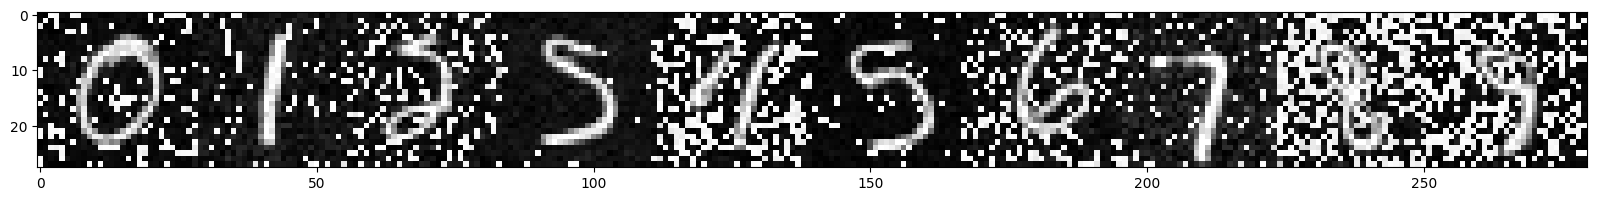

 42%|███████████████████▏                         | 21250/50000 [41:47<58:08,  8.24it/s]

Epoch [21251/10] - Loss Flow Matching: 0.1604 - Loss Generator Matching: 0.0166


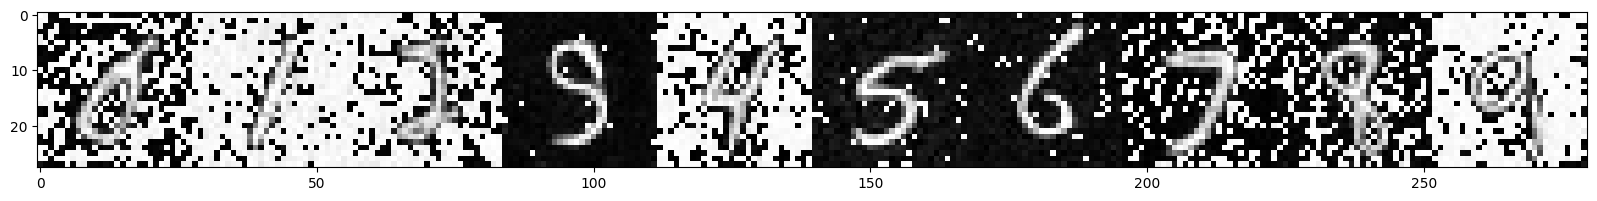

 45%|████████████████████▎                        | 22500/50000 [44:11<55:02,  8.33it/s]

Epoch [22501/10] - Loss Flow Matching: 0.0589 - Loss Generator Matching: 0.0212


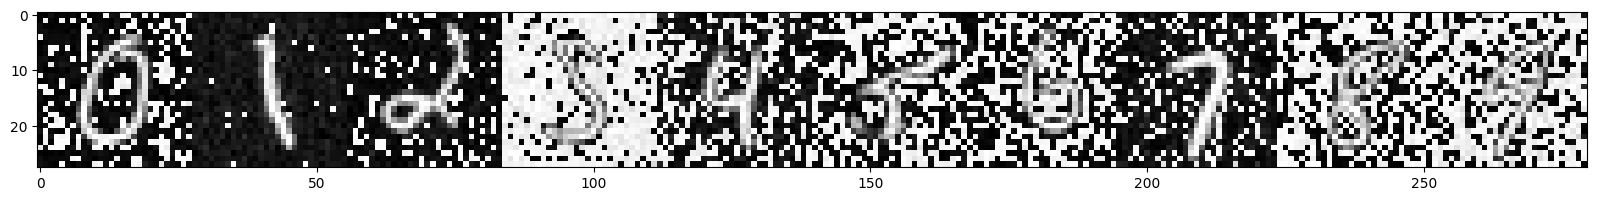

 48%|█████████████████████▍                       | 23750/50000 [46:38<49:04,  8.92it/s]

Epoch [23751/10] - Loss Flow Matching: 0.0982 - Loss Generator Matching: 0.0161


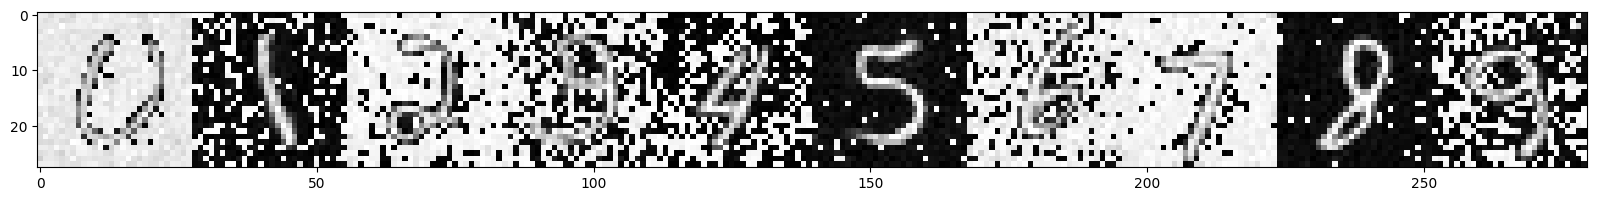

 50%|██████████████████████▌                      | 25000/50000 [49:07<50:04,  8.32it/s]

Epoch [25001/10] - Loss Flow Matching: 0.0910 - Loss Generator Matching: 0.0179


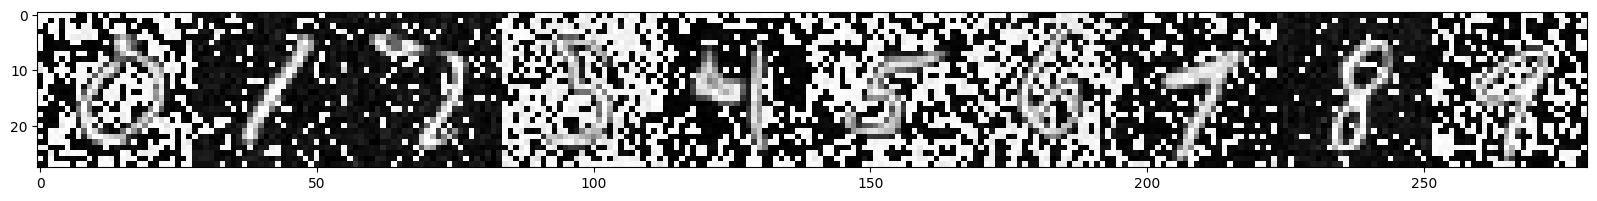

 52%|███████████████████████▋                     | 26250/50000 [51:37<46:34,  8.50it/s]

Epoch [26251/10] - Loss Flow Matching: 0.0680 - Loss Generator Matching: 0.0184


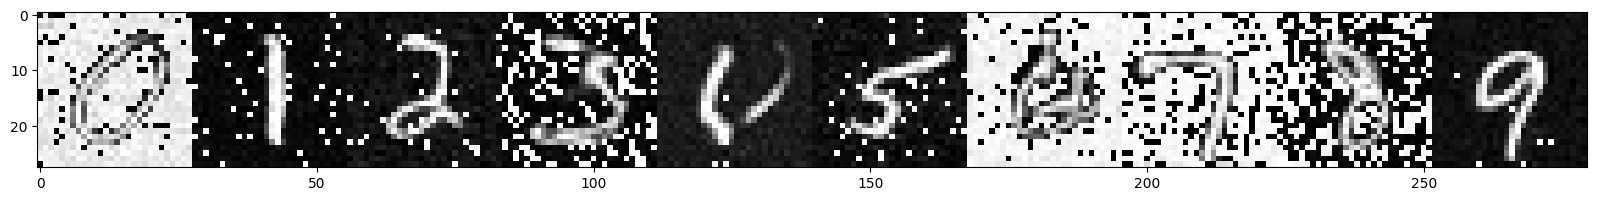

 55%|████████████████████████▊                    | 27500/50000 [54:07<42:39,  8.79it/s]

Epoch [27501/10] - Loss Flow Matching: 0.0753 - Loss Generator Matching: 0.0174


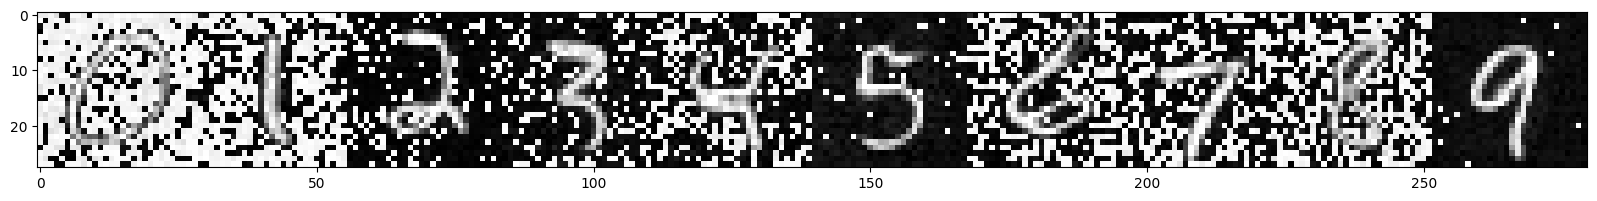

 57%|█████████████████████████▊                   | 28750/50000 [56:35<36:26,  9.72it/s]

Epoch [28751/10] - Loss Flow Matching: 0.0834 - Loss Generator Matching: 0.0246


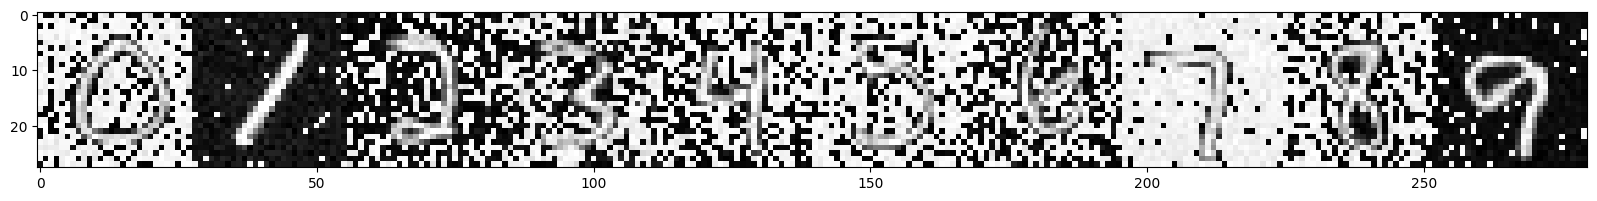

 60%|███████████████████████████                  | 30000/50000 [59:01<40:38,  8.20it/s]

Epoch [30001/10] - Loss Flow Matching: 0.0867 - Loss Generator Matching: 0.0137


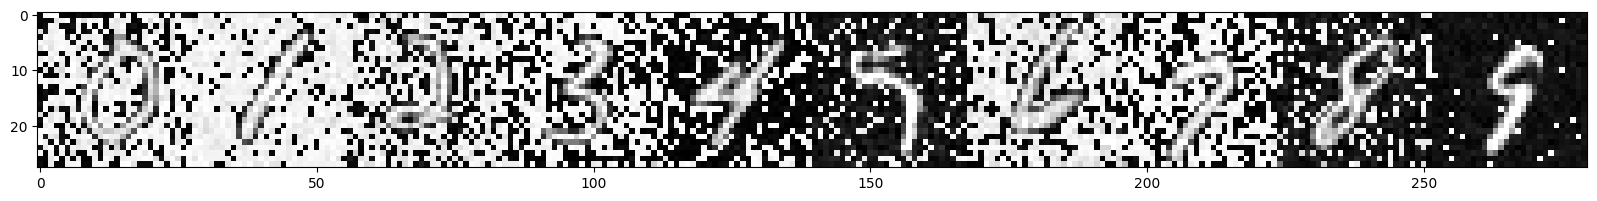

 62%|██████████████████████████▉                | 31250/50000 [1:01:30<38:47,  8.06it/s]

Epoch [31251/10] - Loss Flow Matching: 0.0786 - Loss Generator Matching: 0.0109


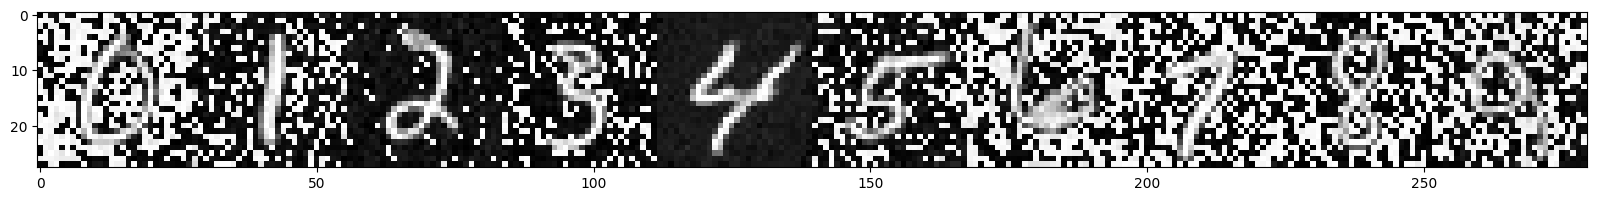

 65%|███████████████████████████▉               | 32500/50000 [1:03:53<34:27,  8.47it/s]

Epoch [32501/10] - Loss Flow Matching: 0.0591 - Loss Generator Matching: 0.0272


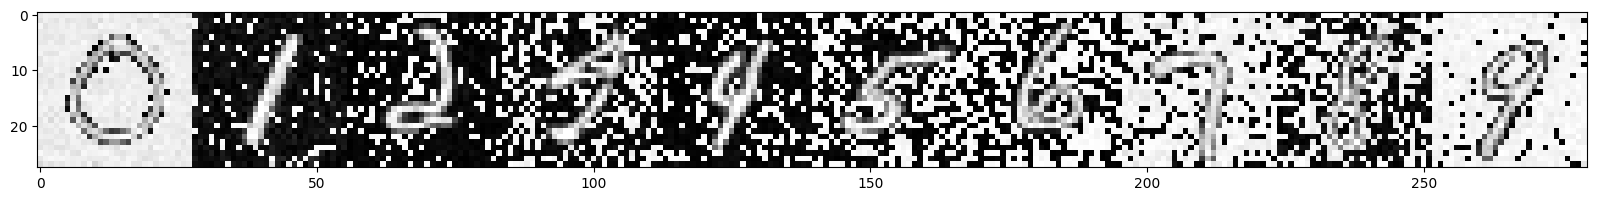

 68%|█████████████████████████████              | 33750/50000 [1:06:22<30:15,  8.95it/s]

Epoch [33751/10] - Loss Flow Matching: 0.0624 - Loss Generator Matching: 0.0178


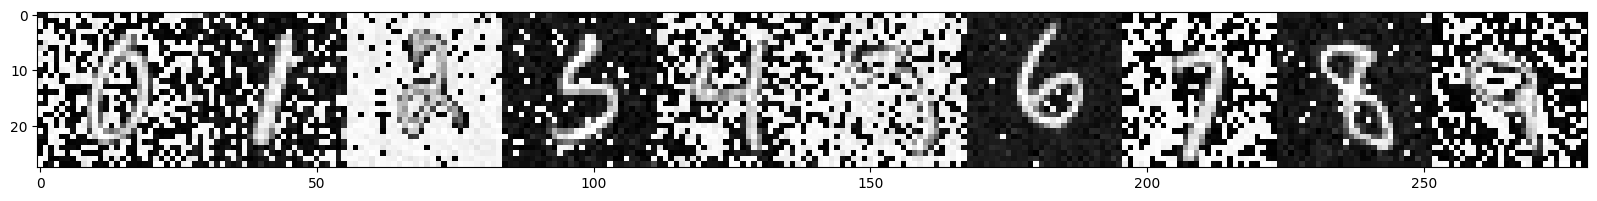

 70%|██████████████████████████████             | 35000/50000 [1:08:49<28:28,  8.78it/s]

Epoch [35001/10] - Loss Flow Matching: 0.0712 - Loss Generator Matching: 0.0128


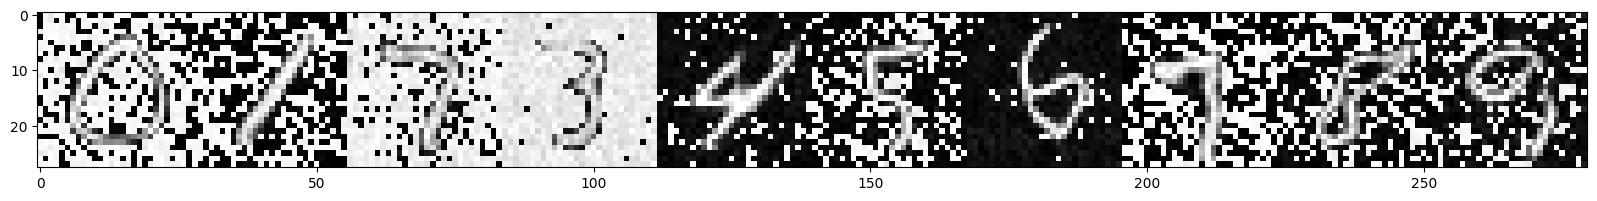

 72%|███████████████████████████████▏           | 36250/50000 [1:11:11<25:41,  8.92it/s]

Epoch [36251/10] - Loss Flow Matching: 0.0803 - Loss Generator Matching: 0.0042


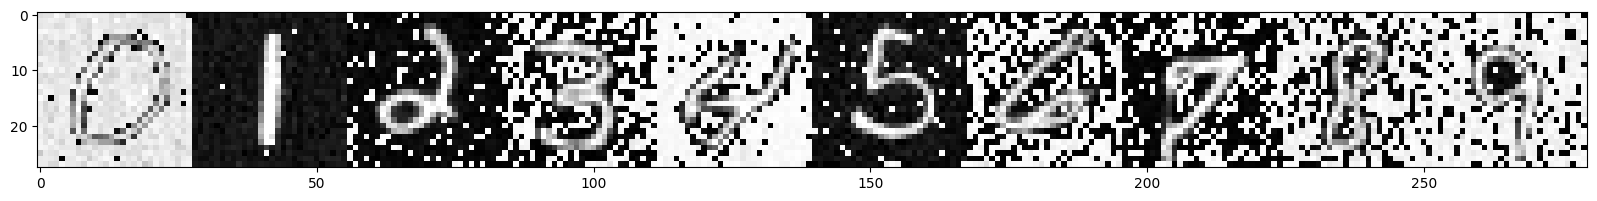

 75%|████████████████████████████████▎          | 37500/50000 [1:13:36<25:12,  8.26it/s]

Epoch [37501/10] - Loss Flow Matching: 0.0559 - Loss Generator Matching: 0.0089


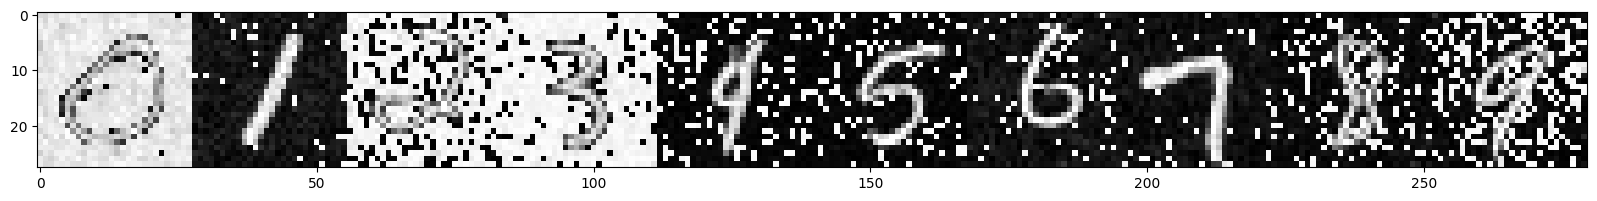

 77%|█████████████████████████████████▎         | 38749/50000 [1:15:59<18:40, 10.04it/s]

Epoch [38751/10] - Loss Flow Matching: 0.0994 - Loss Generator Matching: 0.0103


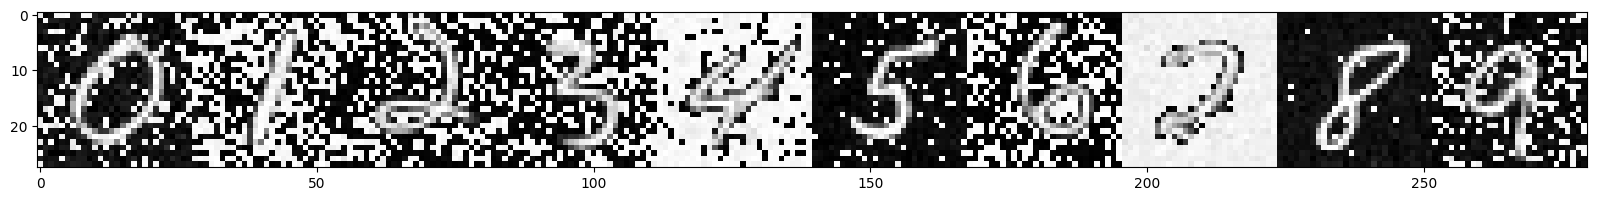

 80%|██████████████████████████████████▍        | 40000/50000 [1:18:19<19:04,  8.74it/s]

Epoch [40001/10] - Loss Flow Matching: 0.0790 - Loss Generator Matching: 0.0087


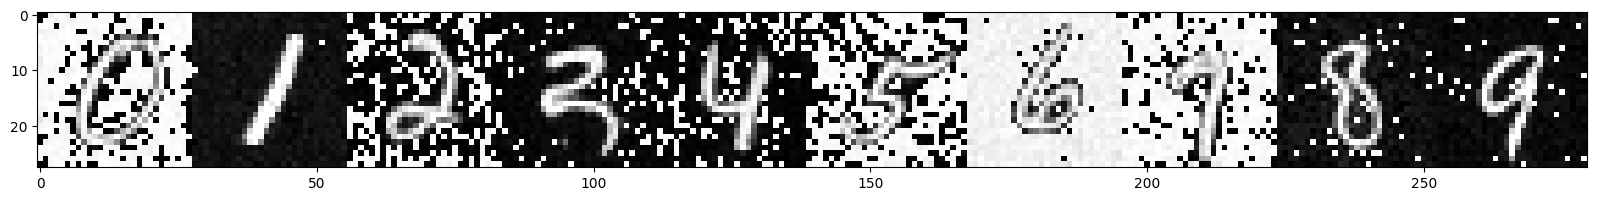

 82%|███████████████████████████████████▍       | 41250/50000 [1:20:45<17:43,  8.23it/s]

Epoch [41251/10] - Loss Flow Matching: 0.0676 - Loss Generator Matching: 0.0101


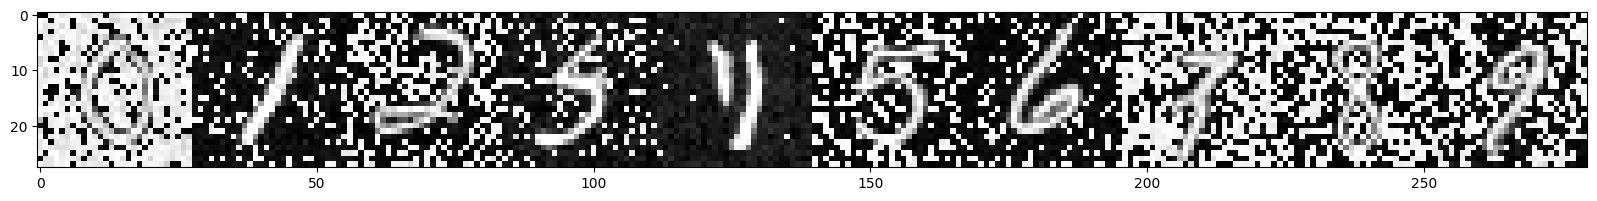

 85%|████████████████████████████████████▌      | 42500/50000 [1:23:09<15:17,  8.17it/s]

Epoch [42501/10] - Loss Flow Matching: 0.0716 - Loss Generator Matching: 0.0052


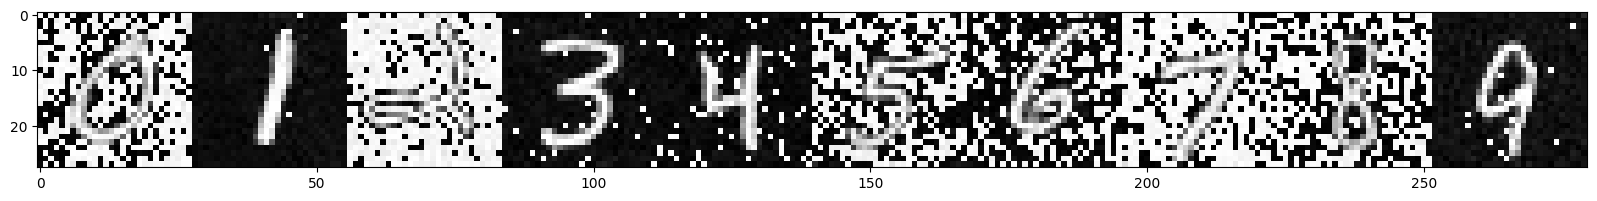

 88%|█████████████████████████████████████▋     | 43750/50000 [1:25:32<11:44,  8.87it/s]

Epoch [43751/10] - Loss Flow Matching: 0.0772 - Loss Generator Matching: 0.0203


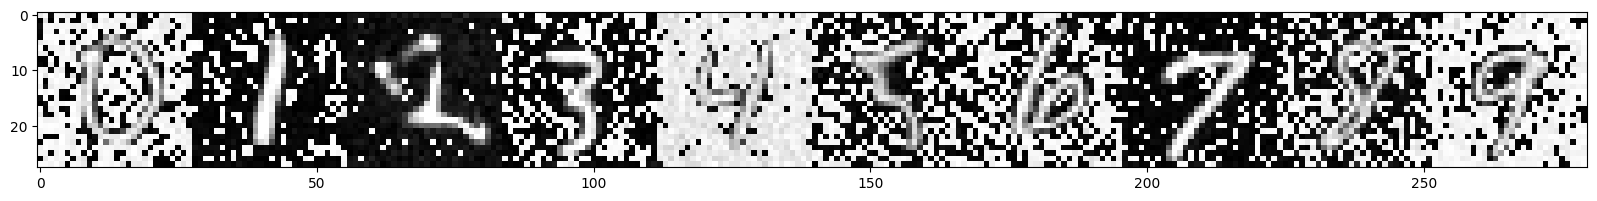

 90%|██████████████████████████████████████▋    | 45000/50000 [1:27:58<10:27,  7.96it/s]

Epoch [45001/10] - Loss Flow Matching: 0.0559 - Loss Generator Matching: 0.0198


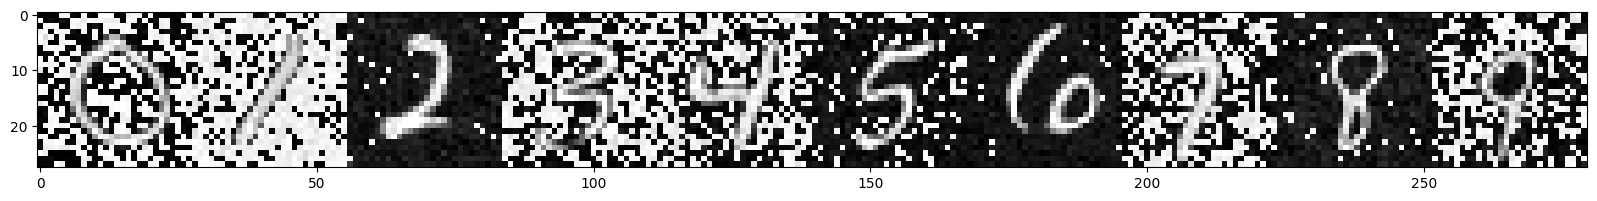

 92%|███████████████████████████████████████▊   | 46250/50000 [1:30:24<07:25,  8.42it/s]

Epoch [46251/10] - Loss Flow Matching: 0.0760 - Loss Generator Matching: 0.0015


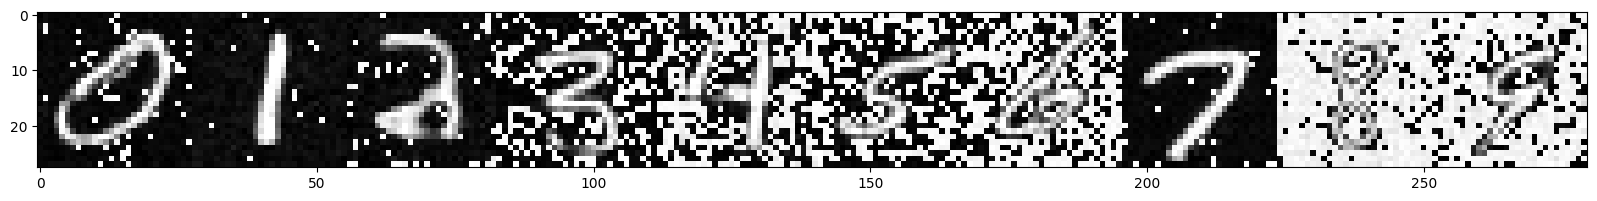

 95%|████████████████████████████████████████▊  | 47500/50000 [1:32:45<04:38,  8.99it/s]

Epoch [47501/10] - Loss Flow Matching: 0.1021 - Loss Generator Matching: 0.0006


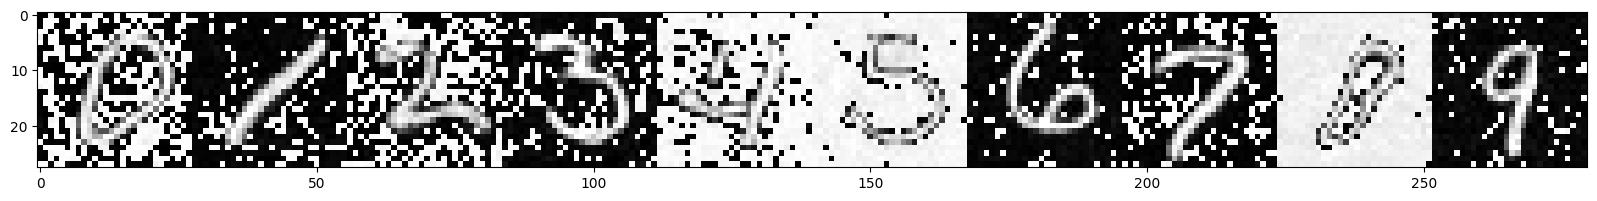

 98%|█████████████████████████████████████████▉ | 48750/50000 [1:35:08<02:23,  8.68it/s]

Epoch [48751/10] - Loss Flow Matching: 0.0681 - Loss Generator Matching: -0.0020


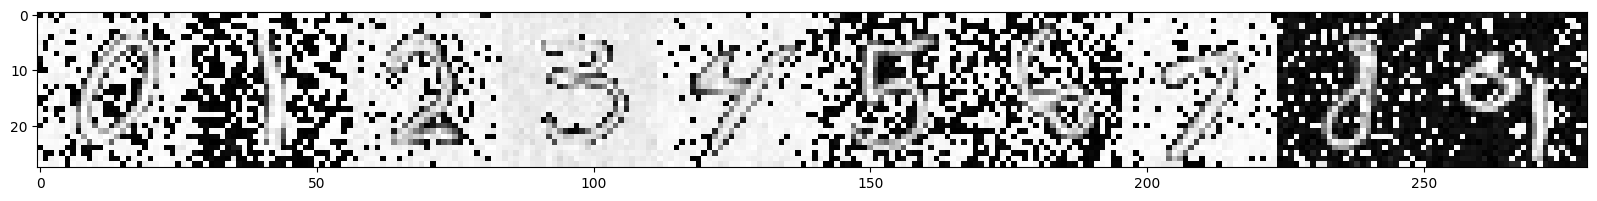

100%|███████████████████████████████████████████| 50000/50000 [1:37:31<00:00,  8.55it/s]


In [ ]:
from torch import autocast
from torch.amp import GradScaler
import os
from datetime import datetime

scaler_online_model = GradScaler()
scaler_generator_model = GradScaler()


if mode_train == 'Generator':
    for param in Pretrained_v_t.parameters():
        param.requires_grad = False  # Freeze Pretrained_v_t

    for epoch in tqdm(range(50000), ncols=88):
        # for x_1, y in data_loader:
        #     x_1 = x_1.to(device)
        #     y = y.to(device)

        loss_FM, loss_GM = 0, 0

        # Freeze Generator and train Online_v_t
        for param in Generator.parameters():
            param.requires_grad = False
        for param in Online_v_t.parameters():
            param.requires_grad = True  # Make sure Online_v_t is trainable

        with autocast(device_type="cuda", dtype=torch.float16):
            loss_flow_matching = model.loss_flow_matching(Online_v_t, Pretrained_v_t, Generator)

        loss_FM += loss_flow_matching.item()
        optimizer_online_model.zero_grad()

        # Scale the gradients and step optimizer for Online_v_t
        scaler_online_model.scale(loss_flow_matching).backward()
        scaler_online_model.step(optimizer_online_model)
        scaler_online_model.update()

        # Freeze Online_v_t and train Generator
        for param in Generator.parameters():
            param.requires_grad = True  # Now we want to train Generator
        for param in Online_v_t.parameters():
            param.requires_grad = False  # Freeze Online_v_t

        with autocast(device_type="cuda", dtype=torch.float16):
            loss_generator_matching, image_gen = model.loss_generator_matching(Online_v_t, Pretrained_v_t, Generator)

        loss_GM += loss_generator_matching.item()
        optimizer_generator_model.zero_grad()

        # Scale the gradients and step optimizer for Generator
        scaler_generator_model.scale(loss_generator_matching).backward()
        scaler_generator_model.step(optimizer_generator_model)
        scaler_generator_model.update()

        if epoch % 1250 == 0:
            print(f"Epoch [{epoch+1}/10] - Loss Flow Matching: {loss_FM:.4f} - Loss Generator Matching: {loss_GM:.4f}")
            plt.figure(figsize=(20, 20))
            grid = make_grid(
                image_gen[:].view([-1, 1,28,28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
            )
            img = ToPILImage()(grid)
            plt.imshow(img)
            plt.show()
            del image_gen

    date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

    if os.path.exists(f"./checkpoints/") == False:
        os.makedirs(f"./checkpoints/")

    if os.path.exists(f"./checkpoints/{dataset_name}/") == False:
        os.makedirs(f"./checkpoints/{dataset_name}/")

    if os.path.exists(f"./checkpoints/{dataset_name}/{date}/") == False:
        os.makedirs(f"./checkpoints/{dataset_name}/{date}/")

    torch.save(Pretrained_v_t.state_dict(), f"./checkpoints/{dataset_name}/{date}/Pretrained_v_t.pt")
    torch.save(Online_v_t.state_dict(), f"./checkpoints/{dataset_name}/{date}/Online_v_t.pt")
    torch.save(Generator.state_dict(), f"./checkpoints/{dataset_name}/{date}/Generator.pt")


In [ ]:
if os.path.exists(f"./checkpoints/") == False:
    os.makedirs(f"./checkpoints/")

if os.path.exists(f"./checkpoints/{dataset_name}/") == False:
    os.makedirs(f"./checkpoints/{dataset_name}/")

if os.path.exists(f"./checkpoints/{dataset_name}/{date}/") == False:
    os.makedirs(f"./checkpoints/{dataset_name}/{date}/")

torch.save(Pretrained_v_t.state_dict(), f"./checkpoints/{dataset_name}/{date}/Pretrained_v_t.pt")
torch.save(Online_v_t.state_dict(), f"./checkpoints/{dataset_name}/{date}/Online_v_t.pt")
torch.save(Generator.state_dict(), f"./checkpoints/{dataset_name}/{date}/Generator.pt")

# Sampling

In [ ]:
N_STEPS = 2
N_SAMPLES = 10
CONDITION = torch.tensor([x for x in range(10)], device=device)
t_steps_solve = torch.linspace(0, 1, N_STEPS, device=device)
# REAL IMAGE
plt.figure(figsize=(20, 20))

image_real = []

amount_label = 10

# Extract image with label
for label in range(amount_label):
    image_index = next((i for i, (img, lbl) in enumerate(data_loader.dataset) if lbl == label), None)
    if image_index is not None:
        image_real.append(data_loader.dataset[image_index])

# Create a figure
plt.figure(figsize=(20, 20))

# Loop through images and plot
for image_idx in range(len(image)):
    plt.subplot(1, amount_label, image_idx + 1)  # Corrected index
    plt.imshow(image_real[image_idx][0].permute(1, 2, 0))  # Permute to (H, W, C) for displaying
    plt.title(f"Label: {image_real[image_idx][1]}")
    plt.axis('off')
# Show the plot
plt.tight_layout()
plt.show()

# GENERATOR IMAGE
with torch.no_grad():
    with torch.autocast(device_type="cuda", dtype=torch.float16):
      traj = torchdiffeq.odeint(
          lambda t, x: Generator(t, x, CONDITION),
          torch.randn(N_SAMPLES, 1, 28, 28, device=device),
          torch.linspace(0, 1, 2, device=device),
          atol=1e-4,
          rtol=1e-4,
          method="euler",
      )

plt.figure(figsize=(20, 20))
grid = make_grid(
    traj[-1, :].view([-1, 1,28,28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()
image_gen = traj[-1]

# Prtrained IMAGE
with torch.no_grad():
    # with torch.autocast(device_type="cuda", dtype=torch.float16):
        traj = torchdiffeq.odeint(
            lambda t, x: Pretrained_v_t(t, x, CONDITION),
            torch.randn(N_SAMPLES, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="euler",
        )

plt.figure(figsize=(20, 20))
grid = make_grid(
    traj[-1, :100].view([-1, 1,28,28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()
image_pretrain = traj[-1]

# FID Metric

In [12]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms as T

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the FID metric and move it to the appropriate device
fid = FrechetInceptionDistance().to(device)

# Assuming image_real and image_gen are lists of tuples (image_tensor, label), you need to extract only the image tensor
image_real_images = [img[0] for img in image_real]  # Extract only the image part
image_gen_images = [img for img in image_gen]    # Extract only the image part

# Stack the list of image tensors into a batch tensor
image_real_tensor = torch.stack(image_real_images).to(device)  # Shape: [N, 1, 28, 28]
image_gen_tensor = torch.stack(image_gen_images).to(device)    # Shape: [N, 1, 28, 28]

print(image_real_tensor.shape)
print(image_gen_tensor.shape)

# Convert grayscale images to RGB (repeat the single channel 3 times)
image_real_tensor = image_real_tensor.repeat(1, 3, 1, 1)  # Shape: [N, 3, 28, 28]
image_gen_tensor = image_gen_tensor.repeat(1, 3, 1, 1)    # Shape: [N, 3, 28, 28]

# Resize images to 299x299, as expected by the InceptionV3 model (FID uses InceptionV3 internally)
resize = T.Resize((299, 299))
image_real_tensor = resize(image_real_tensor)
image_gen_tensor = resize(image_gen_tensor)

# Ensure the images are in the correct range [0, 255] and dtype torch.uint8
image_real_tensor = (image_real_tensor * 255).clamp(0, 255).to(torch.uint8)
image_gen_tensor = (image_gen_tensor * 255).clamp(0, 255).to(torch.uint8)

# Update FID metric with real and generated images
fid.update(image_real_tensor, real=True)  # Real images
fid.update(image_gen_tensor, real=False)  # Generated images

# Compute the FID score
fid_score = fid.compute()

# Print the FID score
print("FID Score on Generator:", fid_score)


torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])
FID Score on Generator: tensor(184.6646)


In [13]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms as T

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the FID metric and move it to the appropriate device
fid = FrechetInceptionDistance().to(device)

# Assuming image_real and image_gen are lists of tuples (image_tensor, label), you need to extract only the image tensor
image_real_images = [img[0] for img in image_real]  # Extract only the image part
image_gen_images = [img for img in image_pretrain]    # Extract only the image part

# Stack the list of image tensors into a batch tensor
image_real_tensor = torch.stack(image_real_images).to(device)  # Shape: [N, 1, 28, 28]
image_gen_tensor = torch.stack(image_gen_images).to(device)    # Shape: [N, 1, 28, 28]

print(image_real_tensor.shape)
print(image_gen_tensor.shape)

# Convert grayscale images to RGB (repeat the single channel 3 times)
image_real_tensor = image_real_tensor.repeat(1, 3, 1, 1)  # Shape: [N, 3, 28, 28]
image_gen_tensor = image_gen_tensor.repeat(1, 3, 1, 1)    # Shape: [N, 3, 28, 28]

# Resize images to 299x299, as expected by the InceptionV3 model (FID uses InceptionV3 internally)
resize = T.Resize((299, 299))
image_real_tensor = resize(image_real_tensor)
image_gen_tensor = resize(image_gen_tensor)

# Ensure the images are in the correct range [0, 255] and dtype torch.uint8
image_real_tensor = (image_real_tensor * 255).clamp(0, 255).to(torch.uint8)
image_gen_tensor = (image_gen_tensor * 255).clamp(0, 255).to(torch.uint8)

# Update FID metric with real and generated images
fid.update(image_real_tensor, real=True)  # Real images
fid.update(image_gen_tensor, real=False)  # Generated images

# Compute the FID score
fid_score = fid.compute()

# Print the FID score
print("FID Score on Pretrained:", fid_score)


torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])
FID Score on Pretrained: tensor(347.7971)
